# Load dataset & preprocessing

In [2]:
import pandas as pd
import numpy as np
import os

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/vecLSTM_noTemp/"

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

df = pd.read_csv(data_path)

In [5]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [6]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [7]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

In [8]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]

In [9]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [10]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [11]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [12]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Rh"]]
test_xs_df = test_df["Holiday"]

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()

std_scaler.fit(train_ys_df)
train_scaled_ys = std_scaler.transform(train_ys_df)

In [14]:
import joblib

joblib.dump(std_scaler, exp_dir + 'std_scaler.joblib')

['datasets/infuluenza/vecLSTM_noTemp/std_scaler.joblib']

In [15]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

train_scaled_ts = (np.array(train_ts_df) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

(array([596.,  46.,  33.,  20.,  10.,  13.,  11.,   4.,  12.,   6.,   2.,
          5.,   3.,   2.,   1.,   4.,   1.,   2.,   3.,   1.,   0.,   0.,
          3.,   0.,   2.]),
 array([0.     , 0.25252, 0.50504, 0.75756, 1.01008, 1.2626 , 1.51512,
        1.76764, 2.02016, 2.27268, 2.5252 , 2.77772, 3.03024, 3.28276,
        3.53528, 3.7878 , 4.04032, 4.29284, 4.54536, 4.79788, 5.0504 ,
        5.30292, 5.55544, 5.80796, 6.06048, 6.313  ]),
 <BarContainer object of 25 artists>)

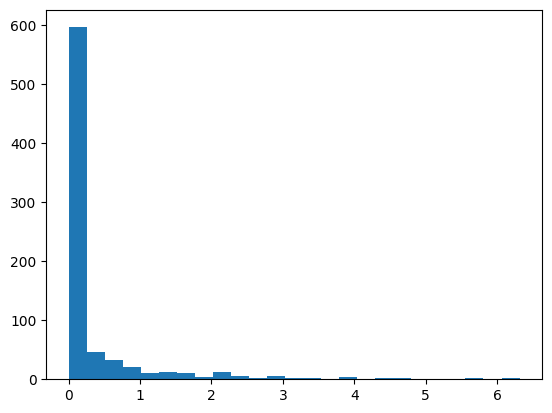

In [17]:
import matplotlib.pyplot as plt

plt.hist(train_scaled_ts,bins=25)

In [18]:
train_ts_np, train_ys_np, train_xs_np = train_scaled_ts, train_scaled_ys, np.array(train_xs_df)
test_ts_np, test_ys_np, test_xs_np = np.array(test_ts_df), np.array(test_ys_df), np.array(test_xs_df)

In [19]:
train_ts_np.shape, train_ys_np.shape, train_xs_np.shape

((780,), (780, 1), (780,))

# Make Dataset

In [20]:
train_np = np.concatenate([train_ts_np.reshape(-1,1), train_ys_np, train_xs_np.reshape(-1,1)], axis = 1)
test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

In [21]:
train_np.shape, test_np.shape

((780, 3), (260, 3))

In [22]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [23]:
#何週前のデータから予測するか

seq_length = 13

train_Xs, train_ys = make_sequence_data(train_np, seq_length)

In [24]:
train_Xs.shape, train_ys.shape

((767, 13, 3), (767, 1, 3))

In [25]:
np.save(exp_dir + "train_X_" + str(seq_length) + "w.npy", train_Xs)
np.save(exp_dir + "train_y_" + str(seq_length) + "w.npy", train_ys)

In [26]:
np.save(exp_dir + "train_np.npy", train_np)
np.save(exp_dir + "test_np.npy", test_np)

# Dataset and DataLoader

In [27]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [21]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/vecLSTM_noTemp/"

In [28]:
train_Xs = np.load(exp_dir + "train_X_" + str(seq_length) + "w.npy")
train_ys = np.load(exp_dir + "train_y_" + str(seq_length) + "w.npy")

In [29]:
train_Xs.shape, train_ys.shape

((767, 13, 3), (767, 1, 3))

In [30]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(exp_dir + 'std_scaler.joblib')

In [31]:
import pandas as pd

labels = train_ys[:,:,0]
print(labels[:,0].shape)
binned_labels = pd.qcut(labels[:,0], q=10, labels=False, duplicates='drop')

(767,)


In [32]:
import numpy as np
from sklearn.model_selection import train_test_split

train_Xs, val_Xs, train_ys, val_ys = train_test_split(
    train_Xs, train_ys, test_size=0.20, stratify=binned_labels, random_state=42
)

In [33]:
np.save(exp_dir + "train_Xs_" + str(seq_length) + "w.npy", train_Xs)
np.save(exp_dir + "train_ys_" + str(seq_length) + "w.npy", train_ys)
np.save(exp_dir + "val_Xs_" + str(seq_length) + "w.npy", val_Xs)
np.save(exp_dir + "val_ys_" + str(seq_length) + "w.npy", val_ys)